<a href="https://colab.research.google.com/github/andersonmdcanteli/wordle/blob/main/wordle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mastering WORDLE

WORDLE is a challenging game created by Josh Wardle that is currently available by [The New York Times Company](https://www.nytimes.com/games/wordle/index.html), where players have six chances to guess a five-letter word. Simple but challenging (especially for non-English-speaking people like me).

At each attempt, feedback is given indicating which letters are present in the word of the day:

- If the letter is in the correct position, the space that the letter occupies turns green;
- If the letter is present in the word, but in the wrong position, the space that the letter occupies turns yellow;
- If the letter is not part of the word, the space the letter occupies becomes black.

In addition to getting the word right, the game challenges you to get the word right in as few attempts as possible! For this, two variables are important:

- Have a good vocabulary;
- Choose good words to guess, especially in the first two guesses;

Improving vocabulary is something that is done over time; However, the choice of words to guess in the first tries can be optimized! And that's what we're going to address in this article. I will try to answer two questions:

1) what is the best word to use in the first guess?

2) what are the best pair of words to use in the first two guesses?

I will tackle this task through statistical analysis with Python! Let's go!


## Libraries and versions

To perform this analysis, I'm using [Google Colab](https://colab.research.google.com/drive/1ulRd4zAWIo9Yq6GujbEX7eyp8XhXRCkO?usp=sharing), and the following libraries:

- Python: `3.7.13`
- Pandas: `1.3.5`
- NumPy: `1.21.6`
- matplotlib: `3.2.2`
- Seaborn: `0.11.2`
- SciPy: `1.7.3`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

## Data collection and analysis

To find out what the best first guesses are, we need a dataset to analyze! WORDLE uses two datasets: one containing only the answers and another containing the accepted words, which are available in this [repository](https://gist.github.com/cfreshman/).

We can import the data using pandas:


In [2]:
df_answers = pd.read_csv(
    "https://gist.githubusercontent.com/cfreshman/a03ef2cba789d8cf00c08f767e0fad7b/raw/28804271b5a226628d36ee831b0e36adef9cf449/wordle-answers-alphabetical.txt",
    header=None, 
    names=['words'])
df_answers.head(2)

,words
0,aback
1,abase


In [3]:
df_answers.describe().transpose()

,count,unique,top,freq
words,2315,2315,aback,1


There are 2315 unique words that can be used as the word of the day.

Now let's get the words that are allowed but not used as the word of the day:

In [4]:
df_allowed = pd.read_csv(
    "https://gist.githubusercontent.com/cfreshman/cdcdf777450c5b5301e439061d29694c/raw/b8375870720504ecf89c1970ea4532454f12de94/wordle-allowed-guesses.txt",
    header=None, 
    names=['words'])
df_allowed.head(2)

,words
0,aahed
1,aalii


In [5]:
df_allowed.describe().transpose()

,count,unique,top,freq
words,10657,10657,aahed,1


There are 10657 words that can be used in the game, but they are not the word of the day.

Hence, we have `10657 + 2315 = 12972` words that can be used. And now we need to find out which ones are the best guess. We can combine these two datasets and get a dataset with all the words that can be used. To do this, we just need to concatenate the two datasets:



In [6]:
df_wordle = pd.concat([df_answers, df_allowed], axis=0)
df_wordle.reset_index(drop=True, inplace=True)
df_wordle.head(2)

,words
0,aback
1,abase


In [7]:
df_wordle.describe().transpose()

,count,unique,top,freq
words,12972,12972,aback,1


Now we need to decide which of these datasets to use. For this, we will estimate the frequency of each letter in each dataset.

I will transform each word into a list, where each element of this list will be composed of a single letter:

In [8]:
df_answers['letters'] = df_answers['words'].apply(list)
df_allowed['letters'] = df_allowed['words'].apply(list)
df_wordle['letters'] = df_wordle['words'].apply(list)
df_answers.head(2)

,words,letters
0,aback,"[a, b, a, c, k]"
1,abase,"[a, b, a, s, e]"


Next, let's create a new data frame for each dataset containing 5 columns, where each cell will have a single letter, and each line will have a single word:

In [9]:
df_answers_letters = pd.DataFrame(df_answers['letters'].to_list(), columns=np.arange(1, 6)).copy()
df_allowed_letters = pd.DataFrame(df_allowed['letters'].to_list(), columns=np.arange(1, 6)).copy()
df_wordle_letters = pd.DataFrame(df_wordle['letters'].to_list(), columns=np.arange(1, 6)).copy()
df_answers_letters.head(2)

,1,2,3,4,5
0,a,b,a,c,k
1,a,b,a,s,e


Next, we need to count the number of letters presented in each dataset. This is easily done by applying the `pd.value_counts` method on each `DataFrame`:

In [10]:
df_answers_letters = df_answers_letters.apply(pd.value_counts)
df_allowed_letters = df_allowed_letters.apply(pd.value_counts)
df_wordle_letters = df_wordle_letters.apply(pd.value_counts)
df_answers_letters.head(2)

,1,2,3,4,5
a,141.0,304,307,163.0,64.0
b,173.0,16,57,24.0,11.0


The `df_answers` has:

- `141` letters `a` in the first position;
- `304` letters `a` in the first position;
- `307` letters `a` in the first position;
- `163` letters `a` in the first position;
- `64` letters `a` in the first position;




In [11]:
df_allowed_letters.head(2)

,1,2,3,4,5
a,596,1959,929,911,616
b,736,65,278,219,48



The `df_allowed_letters` has:

- `596` letters `a` in the first position;
- `1959` letters `a` in the second position;
- `929` letters `a` in the third position;
- `911` letters `a` in the fourth position;
- `616` letters `a` in the fifth position;

A similar behavior is observed in the other letters, which was a expected result since there are 5 times more allowed words than answer words.

We need to know if the distributions of these two datasets are similar or not. We need to calculate the ratio between the number of each letter in relation to the total number of letters. For this, I will sum the 5 five columns to get the total amount of each letter:


In [12]:
df_answers_letters['sum'] = df_answers_letters.sum(axis=1)
df_allowed_letters['sum'] = df_allowed_letters.sum(axis=1)
df_wordle_letters['sum'] = df_wordle_letters.sum(axis=1)
df_answers_letters.head(2)

,1,2,3,4,5,sum
a,141.0,304,307,163.0,64.0,979.0
b,173.0,16,57,24.0,11.0,281.0


We need to know the total number of letters. To do this, just add the entire sum column

In [13]:
total_sum_answers_letters = df_answers_letters['sum'].sum()
print(total_sum_answers_letters)
total_sum_allowed_letters = df_allowed_letters['sum'].sum()
print(total_sum_allowed_letters)
total_sum_wordle_letters = df_wordle_letters['sum'].sum()

11575.0
53285


And then we normalize the sum column, dividing it by the total number of letters in the dataset. In this way, we obtain the frequency of each letter in the respective datasets:

In [14]:
df_answers_letters['frequency_answers'] = df_answers_letters['sum']/total_sum_answers_letters
df_allowed_letters['frequency_allowed'] = df_allowed_letters['sum']/total_sum_allowed_letters
df_wordle_letters['frequency_wordle'] = df_wordle_letters['sum']/total_sum_wordle_letters
df_answers_letters.head(2)

,1,2,3,4,5,sum,frequency_answers
a,141.0,304,307,163.0,64.0,979.0,0.084579
b,173.0,16,57,24.0,11.0,281.0,0.024276


A better visualization of the results can be done through a bar graph:

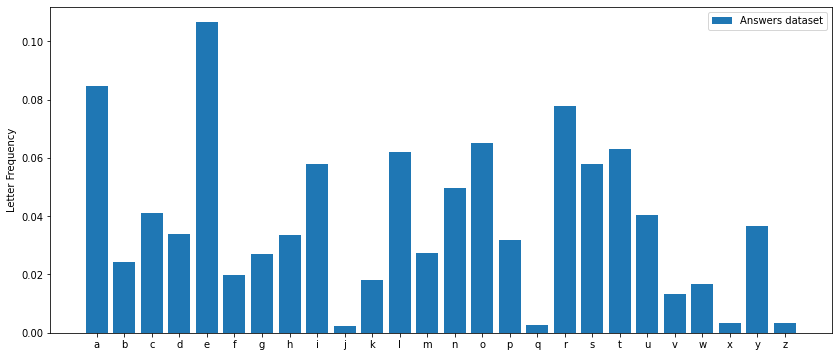

In [15]:
plt.figure(figsize=(14,6))
plt.bar(df_answers_letters.index, df_answers_letters['frequency_answers'], label="Answers dataset")
plt.ylabel("Letter Frequency")
plt.legend()
plt.show()

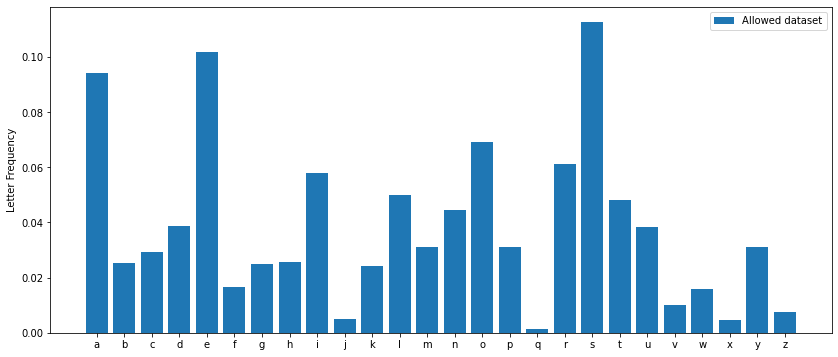

In [16]:
plt.figure(figsize=(14,6))
plt.bar(df_allowed_letters.index, df_allowed_letters['frequency_allowed'], label="Allowed dataset")
plt.ylabel("Letter Frequency")
plt.legend()
plt.show()

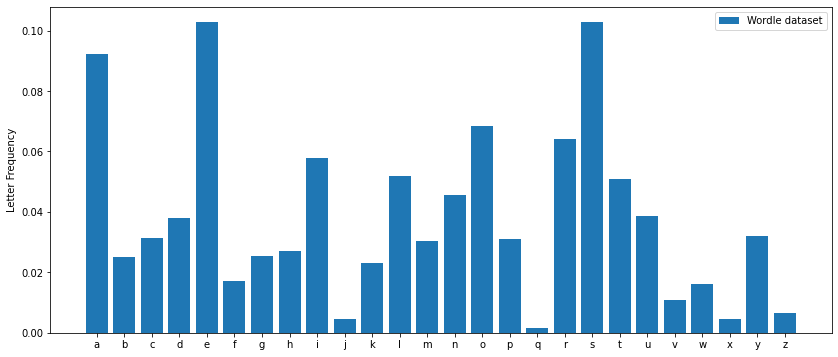

In [17]:
plt.figure(figsize=(14,6))
plt.bar(df_wordle_letters.index, df_wordle_letters['frequency_wordle'], label="Wordle dataset")
plt.ylabel("Letter Frequency")
plt.legend()
plt.show()

To better compare the results, let's plot a stacked bar chart. First, we concat the results on a new `DataFrame`:

In [18]:
df_comparison = pd.concat(
    [df_answers_letters['frequency_answers'], df_allowed_letters['frequency_allowed'], df_wordle_letters['frequency_wordle']], 
    axis=1)
df_comparison.rename(columns = {
    'frequency_answers': 'Answers', 
    'frequency_allowed': 'Allowed',
    'frequency_wordle': 'Wordle',
    }, inplace=True)
df_comparison.head(2)

,Answers,Allowed,Wordle
a,0.084579,0.094041,0.092353
b,0.024276,0.025260,0.025085


And then we plot the graphs:

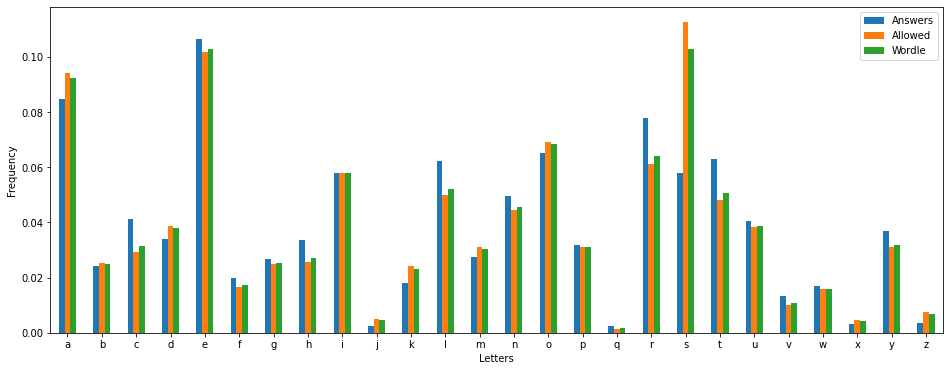

In [19]:
fig, ax = plt.subplots(figsize=(16,6))
df_comparison.plot.bar(ylabel="Frequency", xlabel="Letters", ax=ax, rot=0)
plt.show()

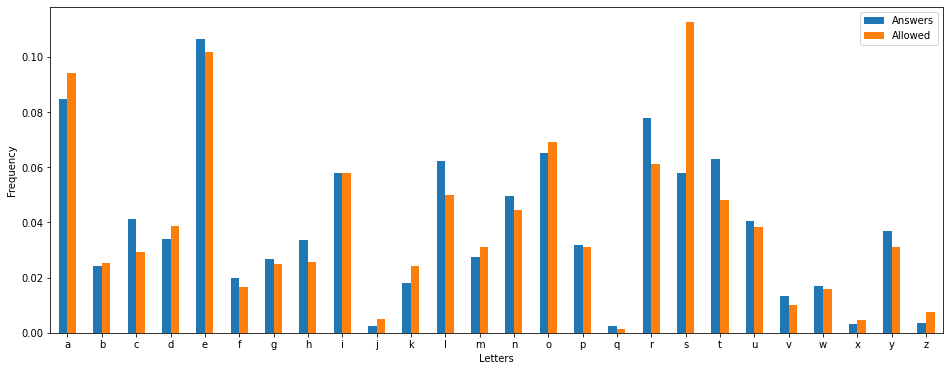

In [20]:
fig, ax = plt.subplots(figsize=(16,6))
df_comparison[['Answers', 'Allowed']].plot.bar(ylabel="Frequency", xlabel="Letters", ax=ax, rot=0)
plt.show()

We observe that the vast majority of letters have a similar frequency. The exception that seems to stand out is the letter `s` which is more frequent in the allowed data set than in the accepted answer data set. 

A more suitable way of making this comparison is through the correlation between the two sets of data. The correlation is easily obtained through linear regression:

In [21]:
lin_reg = stats.linregress(df_comparison['Answers'], df_comparison['Allowed'])
lin_reg

LinregressResult(slope=0.9820907962180238, intercept=0.0006888155300759993, rvalue=0.9007384288161436, pvalue=3.6086718115836617e-10, stderr=0.09667163830537892, intercept_stderr=0.0045265435584302995)

As the value of $r$ is close to `1` (`0.90`) , this indicates that the two data sets are similar; but let's generate the correlation graph between the two sets to see the correlation. 

In [22]:
df_comparison['regression'] = df_comparison['Answers']*lin_reg[0] + lin_reg[1]
df_comparison.head(2)

,Answers,Allowed,Wordle,regression
a,0.084579,0.094041,0.092353,0.083753
b,0.024276,0.025260,0.025085,0.024531


Now let's plot the graph. I'll take the opportunity to add each letter next to its respective point to improve the visualization of the results

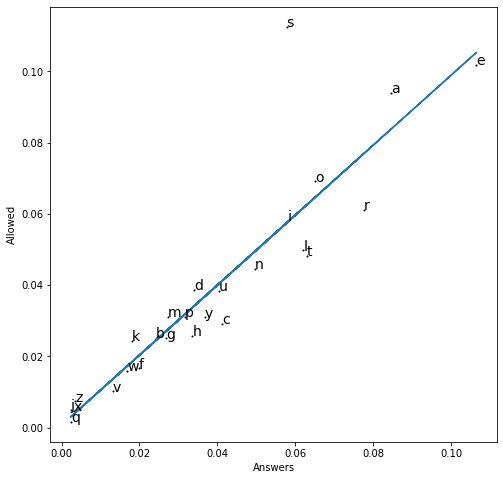

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_comparison['Answers'], df_comparison['Allowed'], c='k', s=1)
ax.set_xlabel("Answers")
ax.set_ylabel("Allowed")
for index in df_comparison.index:
  ax.annotate(index, 
               (df_comparison[df_comparison.index.str.startswith(index)]['Answers'],
                df_comparison[df_comparison.index.str.startswith(index)]['Allowed']),
               fontsize = 14
               )
ax.plot(df_comparison['Answers'], df_comparison['regression'])
plt.show()


As we can see, there is a good correlation between the two data sets. The only exception is the letter `s` which is much more frequent in the allowed words dataset than in the words that might be the solution of the day.

Finally, we can apply a test to verify if the frequencies come from the same distribution. I'll use the Anderson-Darling test for this:

In [24]:
stats.anderson_ksamp([df_comparison['Answers'], df_comparison['Allowed']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: p-value capped: true value larger than 0.25
  """Entry point for launching an IPython kernel.


Anderson_ksampResult(statistic=-0.9618698952626105, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

As the p-value is higher than 0.05 (`>0.25`), we have no evidence to reject the hypothesis that the two comes from the same distribution. Hence, we have statistical confidence to combine these two datasets. The only difference, which is a marked difference, is the letter `s`.

## Summary

Now we have to decide which dataset to use. We have 3 options:

1) Use the dataset that has only the answers;

2) Use the dataset that has only the allowed words, but without the answers;

3) Use the dataset with all possible words.

Option 2 is not very useful as it kills the chances of getting the word right on the first try. The other two options seem to be suitable, with the third option likely to lead to a more general result, while the first option is likely to improve the chances to get the word-of-the-day.

I will choose to use the 3 datasets. Thus, we will have chances to compare the results obtained with the different datasets.

Due to the number of words contained in the datasets, the great challenge of this task will be to work with datasets 2 and 3, especially to obtain the best pair of words. We will certainly have millions of unique combinations of information stored as strings, which will take up a lot of memory space. Managing this memory will likely be more complex than the analysis itself.

Well, good luck to us!

### Dataset 1: Only answers

#### First guess

To check the results obtained for the dataset that contains only the words that can be used as the word of the day, [see this notebook]().

#### First two guesses

To check the results obtained for the dataset that contains only the words that can be used as the word of the day, [see this notebook]().